# Generating Word Embeddings 
## Anish Sachdeva (DTU/2K16/MC/013)
## Natural LanguageProcessing by Dr. Seba Susan 


In this notebook, we will practice how to compute word embeddings and use them for sentiment analysis.
- To implement sentiment analysis, we can go beyond counting the number of positive words and negative words. 
- We can find a way to represent each word numerically, by a vector. 
- The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures. 

In this notebook, we will explore a classic way of generating word embeddings or representations.
- We will implement a famous model called the continuous bag of words (CBOW) model. 

By completing this notebook we will:

- Train word vectors from scratch.
- Learn how to create batches of data.
- Understand how backpropagation works.
- Plot and visualize your learned word vectors.

## Outline

- [1 The Continuous bag of words model](#1)
- [2 Training the Model](#2)
    - [2.0 Initialize the model](#2)
    - [2.1 Softmax Function](#2.1)
    - [2.2 Forward Propagation](#2.2)
    - [2.3 Cost Function](#2.3)
    - [2.4 Backproagation](#2.4)
    - [2.5 Gradient Descent](#2.5)
- [3 Visualizing the word vectors](#3)


<a name='1'></a>
# 1. The Continuous bag of words model

Let's take a look at the following sentence: 
>**'I am happy because I am learning'**. 

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if we were to choose a context half-size of say $C = 2$, then we would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am] 

> $C$ words after: [because, I] 

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of our model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='word2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 1 </div>

Where $\bar x$ is the average of all the one hot vectors of the context words. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='mean_vec2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 2 </div>

Once we have encoded all the context words, we can use $\bar x$ as the input to your model. 

The architecture we will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [3]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca

In [4]:
word_tokenize('hello world')

['hello', 'world']

In [5]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [6]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [7]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary:", len(fdist) )
print("Most frequent tokens:", fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary: 5778
Most frequent tokens: [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words
We create a function to create a dictionary that maps words to indices and indices to words.

In [8]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    words = sorted(list(set(data)))
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [9]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5778


In [10]:
# example of word to index mapping
print("Index of the word 'king' :", word2Ind['king'] )
print("Word which has index 2743:", Ind2word[2743] )

Index of the word 'king' : 2745
Word which has index 2743: kindness


<a name='2'></a>
# 2 Training the Model

###  Initializing the model

We will now initialize two matrices and two vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in our vocabulary and $N$ is the dimension of our word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters. 

<a name='ex-01'></a>

We use [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) to generate matrices that are initialized with random values from a uniform distribution, ranging between 0 and 1.

**Note:** In the next cell we use a random seed simply to initialize the same matrix every time so that the results in ths notebook can be repeated and verified.

In [11]:
def initialize_model(N, V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)
    
    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N, 1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V, 1)

    return W1, W2, b1, b2

In [12]:
# Test out function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


<a name='2.1'></a>
### 2.1 Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.

In [13]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    result = np.exp(z)
    return result / np.sum(result, axis=0)

In [14]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

<a name='2.2'></a>
### 2.2 Forward propagation

We Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
\end{align}

For that, we will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

In [15]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    h = W1.dot(x) + b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0, h)
    
    # Calculate z
    z = W2.dot(h) + b2

    return z, h

In [16]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


<a name='2.3'></a>
## 2.3 Cost function

In [17]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat), y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [18]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 9.9560


<a name='2.4'></a>
## 2.4 Training the Model - Backpropagation

We now train the CBOW model <br>
We created a function for the forward propagation. Now We will implement a function that computes the gradients to backpropagate the errors.

In [19]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    def relu(k):
        result = k.copy()
        result[result < 0] = 0
        return result
    
    grad_W1 = (1 / batch_size) * np.dot(relu(np.dot(W2.T, yhat - y)), x.T)
    grad_W2 = (1 / batch_size) * np.dot(yhat - y, h.T)
    grad_b1 = ((1 / batch_size) * relu(np.dot(W2.T, yhat - y))).sum(axis=1, keepdims=True)
    grad_b2 = ((1 / batch_size) * (yhat - y)).sum(axis=1, keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [20]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)


<a name='2.5'></a>
## Gradient Descent

Now that we have implemented a function to compute the gradients, we  will implement batch gradient descent over your training set. 

For that, we will use `initialize_model` and the `back_prop` functions which we just created (and the `compute_cost` function). We can also use the provided `get_batches` helper function:

```python
for x, y in get_batches(data, word2Ind, V, C, batch_size):
   ...
```
    

In [21]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 1
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)
        if (iters % 10 == 0):
            print(f"iters: {iters} cost: {cost:.6f}")
        
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha * grad_W1 
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2
        
        iters += 1 
        if (iters - 1) == num_iters: 
            break
        if (iters - 1) % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [22]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.789141
iters: 20 cost: 0.105543
iters: 30 cost: 0.056008
iters: 40 cost: 0.038101
iters: 50 cost: 0.028868
iters: 60 cost: 0.023237
iters: 70 cost: 0.019444
iters: 80 cost: 0.016716
iters: 90 cost: 0.014660
iters: 100 cost: 0.013054
iters: 110 cost: 0.012133
iters: 120 cost: 0.011370
iters: 130 cost: 0.010698
iters: 140 cost: 0.010100
iters: 150 cost: 0.009566


<a name='3'></a>
## 3.0 Visualizing the word vectors

In this part you will visualize the word vectors trained using the function we just coded above. 

In [23]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2745, 3951, 2961, 3023, 5675, 1452, 5674, 4191, 2316, 4278]


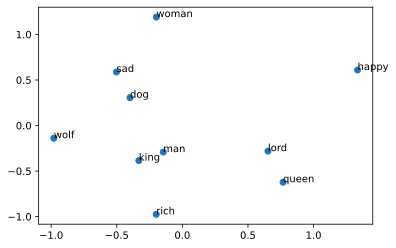

In [24]:
result = compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

You can see that man and king are next to each other. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

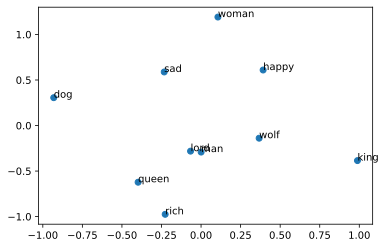

In [25]:
result = compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()